Kaiyue Ma Student ID: 1006714129
Shared the penguins size dataset with Seo Won Yi

**PART I**: Column of Data For PyMC normal-gamma specification

In [35]:
import pandas as pd; import numpy as np; from scipy import stats; import matplotlib.pyplot as plt;
url = 'https://github.com/Kaiyue2003/STA365-Assignments/blob/main/penguins_size.csv?raw=true'
data1 = pd.read_csv(url)
data1.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Histogram output demonstrates that the body mass of penguins is approximately normally distributed though the plot is skewed.

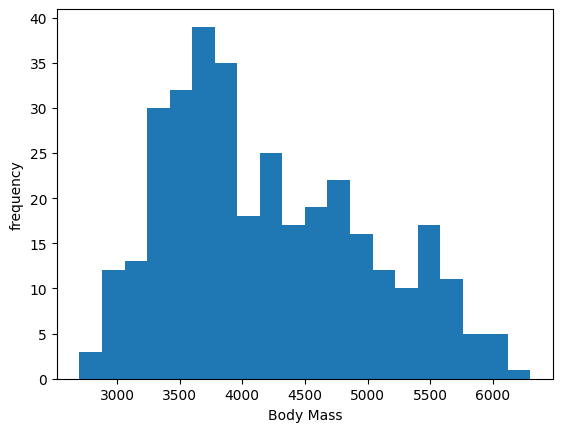

In [36]:
# Exploratory Data Analysis
plt.hist(data1['body_mass_g'],bins=20)
plt.xlabel('Body Mass')
plt.ylabel('frequency')
plt.show()

In [37]:
theta_0,tau=4200,1300;alpha,beta=0.01,0.5
theta_prior = stats.norm(loc=theta_0,scale=tau)
phi_prior = stats.gamma(a=alpha,scale=1/beta)
x = data1['body_mass_g']
filtered_x = x.dropna() # Dropping all not available values
theta_true = np.mean(filtered_x) # Not actually the true theta for the population of penguins. Only for notation simplicity.
phi_true = 1/np.std(filtered_x)
n = len(filtered_x)
print(theta_true)
print(phi_true)
print(n)

4201.754385964912
0.001248780520181531
342


Due to the relatively large spread of the body mass of penguins, phi obtained from the inverse of the standard deviation is merely 0.0012. Nevertheless, parameters utilized to tune the theta prior and phi prior generally function well.

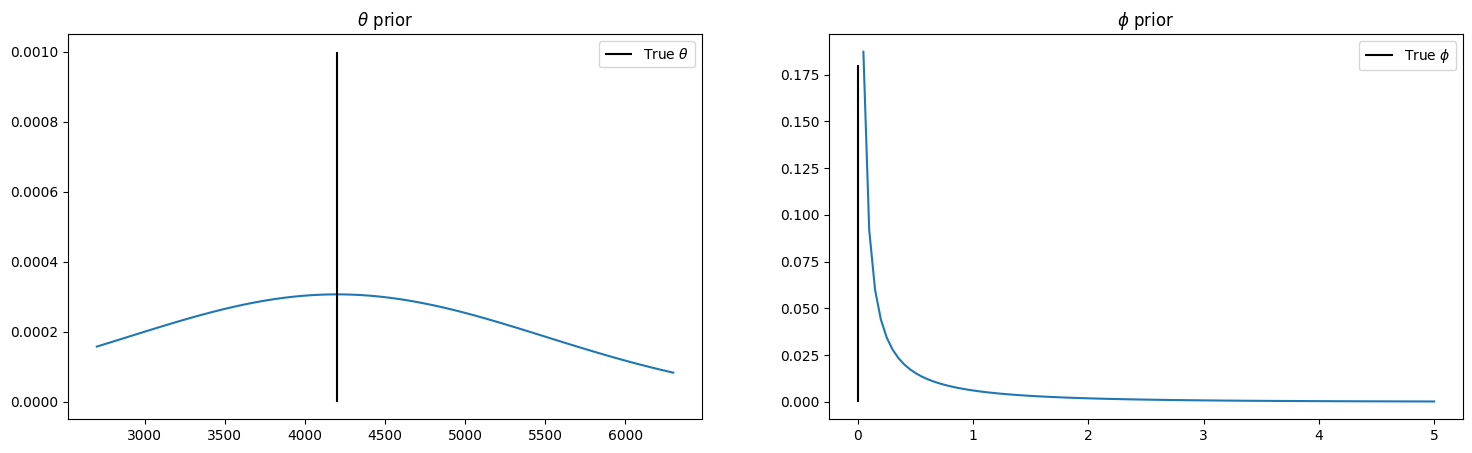

In [38]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt
Rplus = np.linspace(0,5,100); Rpm = np.linspace(2700,6300,100) # Tune the domain of theta prior and phi prior
fig,ax = plt.subplots(1,2,figsize=(18,5)); ax[0].plot(Rpm, theta_prior.pdf(Rpm)); ax[0].set_title('$\\theta$ prior');
ax[0].vlines(theta_true,0,.001,'k',label='True $\\theta$'); ax[0].legend();
ax[1].plot(Rplus, phi_prior.pdf(Rplus)); ax[1].vlines(phi_true,0,.18,'k',label='True $\\phi$');
ax[1].legend(); ax[1].set_title('$\\phi$ prior');

It can be observed from the subplots below that theta MCMC posterior draws concentrate around 4200 which is close to the true theta and sample mean centered at 4201.75. Similarly, phi MCMC posterior draws and sample precision almost coincide with each other around 0 which is not far from true phi centered around 0.0012.

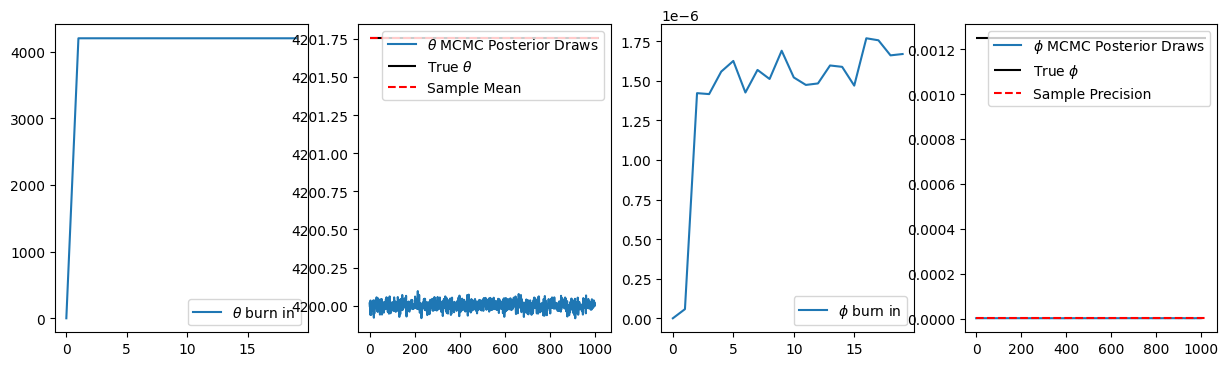

In [39]:
iterations = 1020 # Gibbs Samples
theta_gibbs_posterior_mcmc_draws,phi_gibbs_posterior_mcmc_draws = np.zeros(iterations+1),np.zeros(iterations+1)
for i in range(1, iterations + 1):
    theta_old = theta_gibbs_posterior_mcmc_draws[i-1]
    phi_new = stats.gamma(a = alpha+n/2, scale = (1/(beta+1/2*sum((filtered_x-theta_old)**2)))).rvs()
    phi_gibbs_posterior_mcmc_draws[i] = phi_new
    theta_new = stats.norm(loc= (tau*theta_0+phi_new*sum(filtered_x))/(tau+n*phi_new),
                           scale= 1/np.sqrt(tau+n*phi_new)).rvs()
    theta_gibbs_posterior_mcmc_draws[i] = theta_new

burn = 20
fig,ax = plt.subplots(1,4, figsize=(15,4)); ax[0].plot(theta_gibbs_posterior_mcmc_draws[:burn],label="$\\theta$ burn in");
ax[1].plot(theta_gibbs_posterior_mcmc_draws[burn:],label="$\\theta$ MCMC Posterior Draws"); ax[2].plot(phi_gibbs_posterior_mcmc_draws[:burn], label="$\\phi$ burn in");
ax[3].plot(phi_gibbs_posterior_mcmc_draws[burn:], label="$\\phi$ MCMC Posterior Draws"); ax[1].hlines(theta_true,0,iterations,'k',label='True $\\theta$');
ax[3].hlines(phi_true,0,iterations,'k',label='True $\\phi$'); ax[1].hlines(x.mean(),0,iterations,'r',linestyle='dashed',label='Sample Mean'); ax[1].legend();
ax[3].hlines(1/filtered_x.var(),0,iterations,'r',linestyle='dashed',label='Sample Precision'); ax[3].legend(); ax[0].legend(); ax[2].legend();

From the subplot on the bottom left, a 90 percent credible interval ranges from approximately -0.05 and 0.05 which is equivalent to -50 and 50 based on the scale of e^3. Thus, theta ranges from 4150 and 4250 is accepted by the Bayesian credible interval.

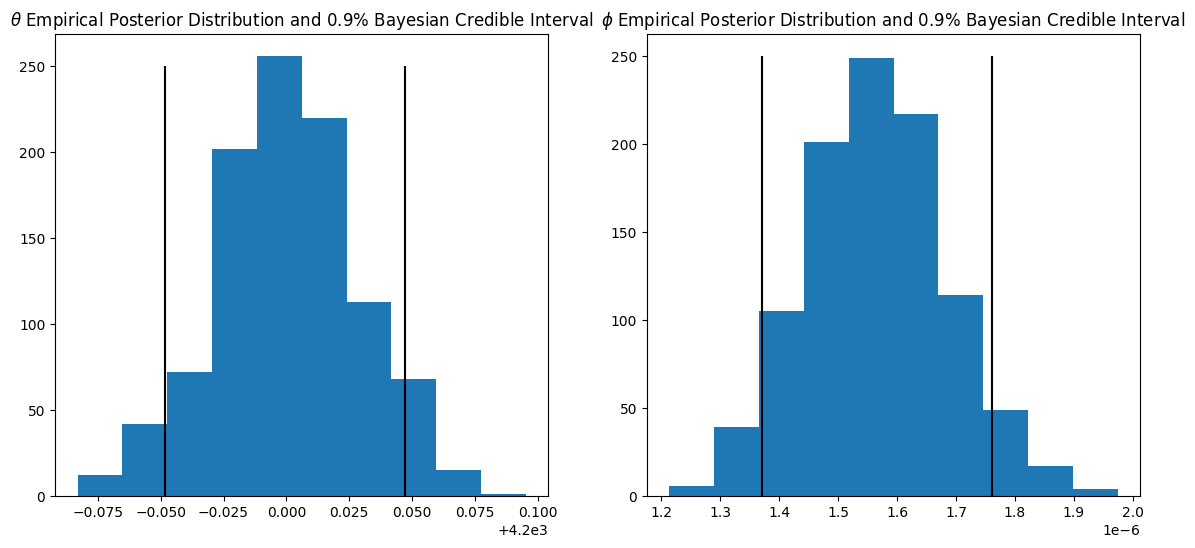

In [40]:
# MCMC estimate posterior means / re-emphsize credible intervals from initial problem
burn_in = 20; BayesianCredibleInterval_probability = 0.90
left_probability = (1-BayesianCredibleInterval_probability)/2
right_probability = left_probability + BayesianCredibleInterval_probability
fig,ax = plt.subplots(1,2,figsize=(14,6))
param=['$\\theta$','$\\phi$']
for i,posterior_samples in enumerate([theta_gibbs_posterior_mcmc_draws, phi_gibbs_posterior_mcmc_draws]):
    BayesianCredibleInterval = np.quantile(posterior_samples[burn_in:],[left_probability, right_probability])
    ax[i].hist(posterior_samples[20:]); ax[i].set_title(param[i]+" Empirical Posterior Distribution and "+str(BayesianCredibleInterval_probability)+"% Bayesian Credible Interval")
    ax[i].vlines(BayesianCredibleInterval,ymin=0,ymax=250,color ='k')

In [41]:
import pymc as pm;
theta_0,tau=4200,1300;alpha,beta=0.01,0.5
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
  theta = pm.Normal("theta",mu=0,sigma=0.01)
  phi = pm.Gamma("phi",alpha=0.01,beta=0.5)
  x_obs = pm.Normal("likelihood",mu=theta,sigma=1/phi**0.5,observed=filtered_x)


In [42]:
with normal_gamma_toy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

with normal_gamma_toy_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=True, tune_interval=0)
    idata_MH = pm.sample(5000,step=MH) # force MH

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:241: RuntimeWarning: invalid value encountered in divide
  self.scaling = tune(self.scaling, self.accepted_sum / float(self.tune_interval))
/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


It can be observed from the subplots below that theta and phi from HMC and MH are generally stationary with constant mean and variance. From the trace plot "Convergence" test, none of the values exceed 1.05. Thus, we fail to reject the hypothesis that chains fail the similarity test. Although, subplot of MH for theta portraits certain disagreements between the straight line and the dashed line, we can't comment that the convergence test is failed.

HMC Split-Rhats {'theta': 1.0018, 'phi': 1.0007} | MH Split-Rhats {'theta': 1.0018, 'phi': 1.0014}


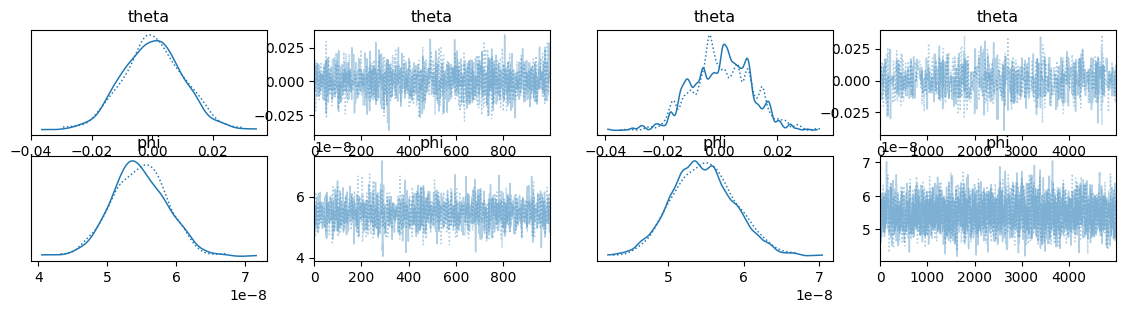

In [43]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})


HMC performs the best in the first 100 iterations compared to MH and Gibbs sampling.

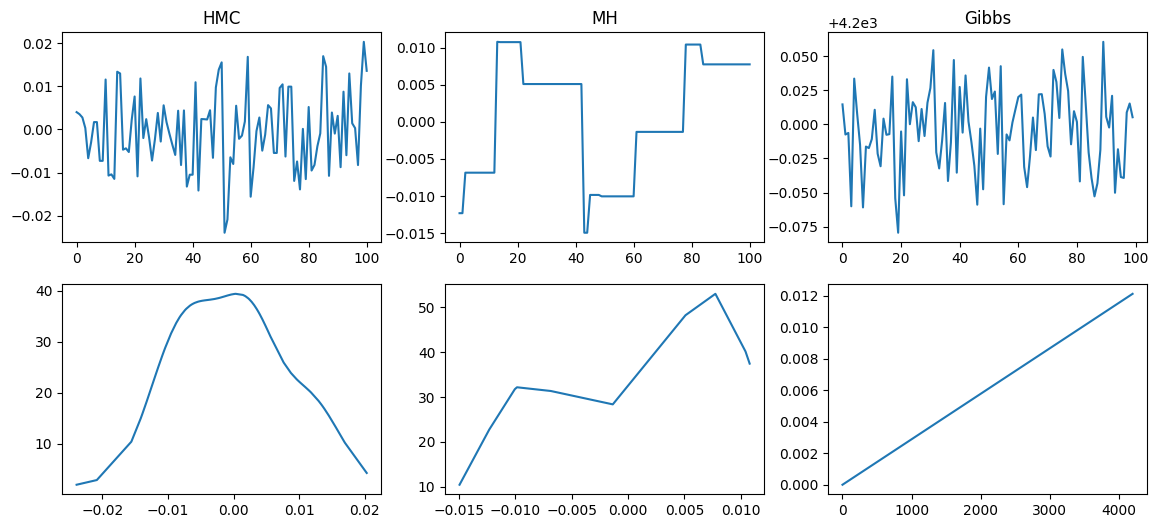

In [44]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,3, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");
ax[0,2].plot(theta_gibbs_posterior_mcmc_draws[burn:(burn+n_mcmc_samples)]); ax[0,2].set_title("Gibbs");
theta_gibbs_posterior_mcmc_draws_sorted = sorted(theta_gibbs_posterior_mcmc_draws);
ax[1,2].plot(theta_gibbs_posterior_mcmc_draws_sorted,gaussian_kde(theta_gibbs_posterior_mcmc_draws_sorted)(theta_gibbs_posterior_mcmc_draws_sorted));

Based on the autocorrelation report, HMC and Gibbs sampling have smaller autocorrelation compared to MH.

Autocorrelation for HMC (MCMC) chain 0.0363029806192913
Autocorrelation for MH (MCMC) chain 0.6792190349195089
Autocorrelation for Gibbs Sampling (MCMC) chain -0.011754075210742456


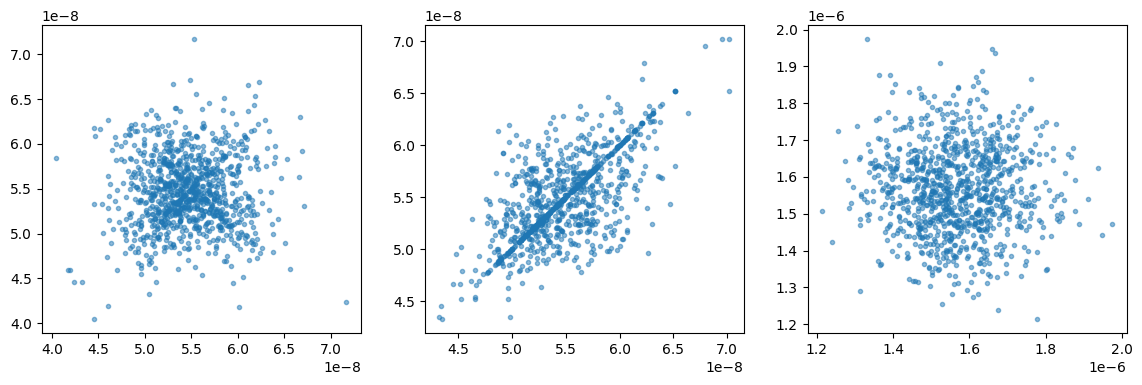

In [45]:
import numpy as np; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,3, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_MH.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_MH.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
ax[2].plot(phi_gibbs_posterior_mcmc_draws[burn:-1],phi_gibbs_posterior_mcmc_draws[(burn+1):], '.', alpha=0.5);
print("Autocorrelation for Gibbs Sampling (MCMC) chain", np.corrcoef(phi_gibbs_posterior_mcmc_draws[burn:-1],phi_gibbs_posterior_mcmc_draws[(burn+1):])[0,1])

The essential tail for theta is approximately 917 out of 2000 samples. The essential tail for phi is about 2172 out of 10000 samples.

In [46]:
import arviz as az; print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html
print("number of MCMC samples:", idata_MH.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

number of MCMC samples: 2000
number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.0,0.01,-0.02,0.02,0.0,0.0,747.49,766.76,1.0
phi,0.0,0.00,0.00,0.00,0.0,0.0,1476.74,1909.51,1.0


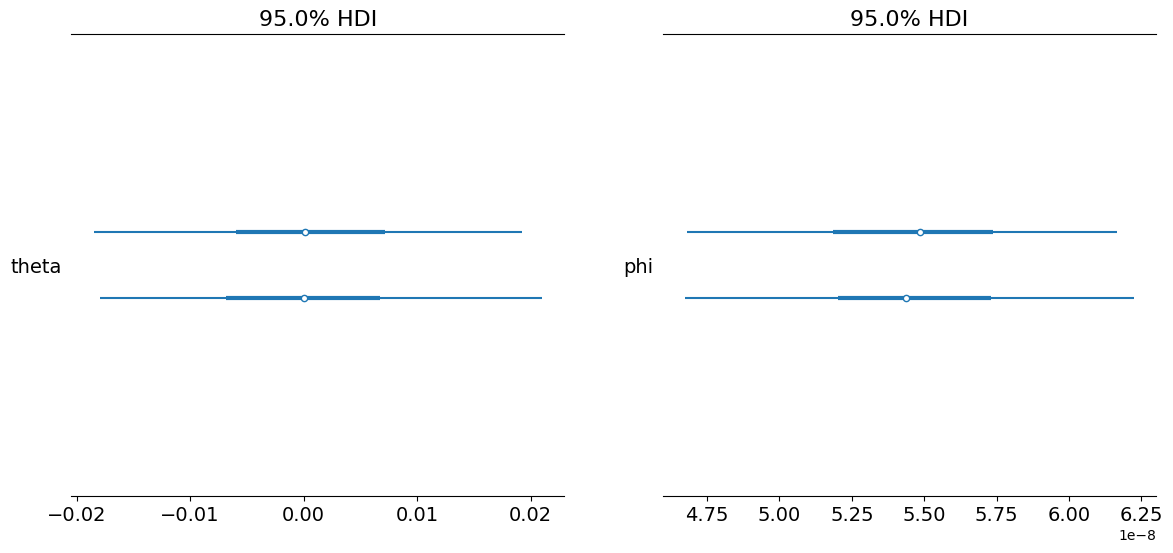

In [47]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

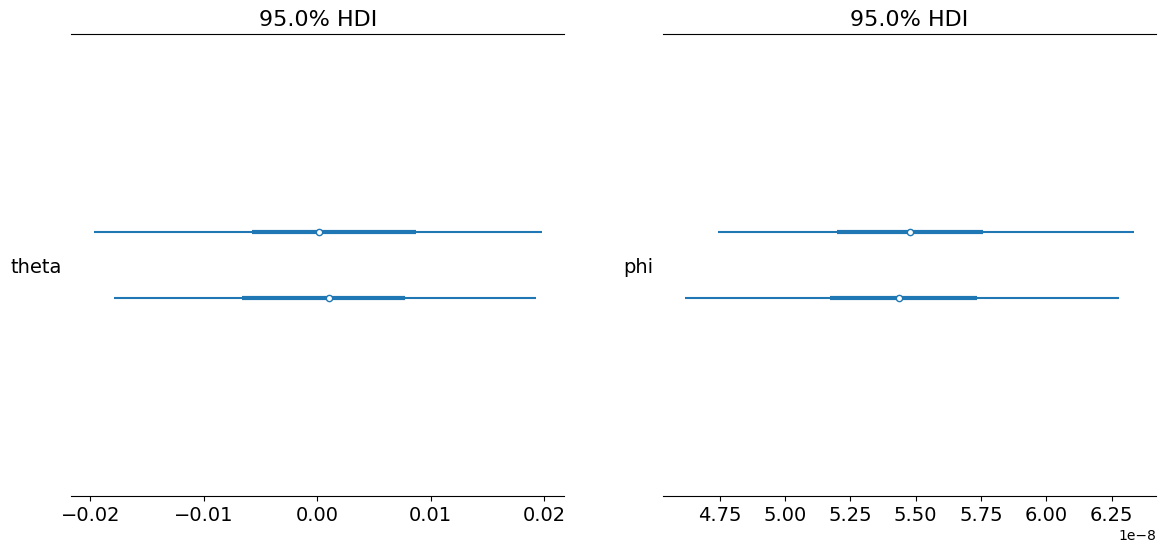

In [48]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_MH, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_MH, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1]);

**PART II**: Column of Data for which a normal-gamma isn't justified

Although it can be easily seen from the histogram that the plot isn't normally distributed, we assume it to be normally distributed for the likelihood function.

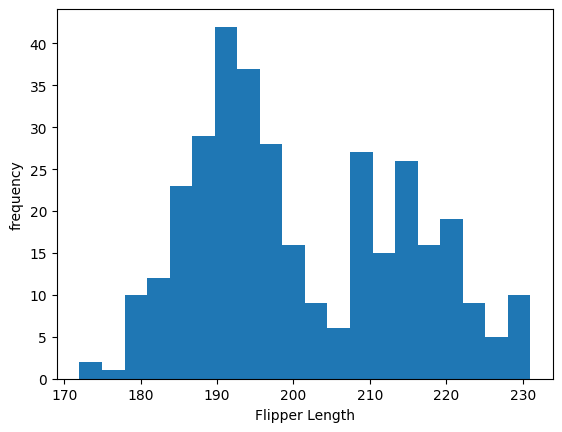

In [49]:
# Exploratory Data Analysis
plt.hist(data1['flipper_length_mm'],bins=20)
plt.xlabel('Flipper Length')
plt.ylabel('frequency')
plt.show()

In [50]:
x1 = data1['flipper_length_mm']
filtered_x1 = x1.dropna() # Dropping all not available values
theta_true1 = np.mean(filtered_x1) # Not actually the true theta for the population of penguins. Only for notation simplicity.
phi_true1 = 1/np.std(filtered_x1)
n1 = len(filtered_x1)
print(theta_true1)
print(phi_true1)
print(n1)

200.91520467836258
0.07121928557834267
342


In [51]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt
a,b=170,240; rate = 2
theta_prior1 = stats.uniform(loc=a,scale=b-a)
phi_prior1 = stats.expon(scale=1/rate)

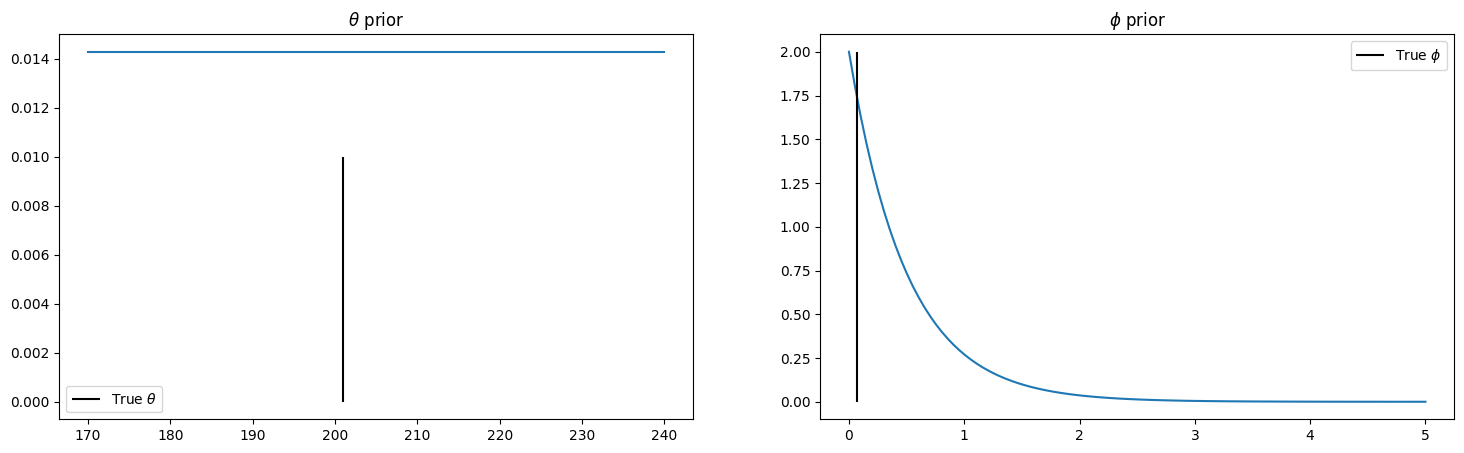

In [52]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt
Rplus1 = np.linspace(0,5,100); Rpm1 = np.linspace(170,240,100) # Tune the domain of theta prior and phi prior
fig,ax = plt.subplots(1,2,figsize=(18,5)); ax[0].plot(Rpm1, theta_prior1.pdf(Rpm1)); ax[0].set_title('$\\theta$ prior');
ax[0].vlines(theta_true1,0,.01,'k',label='True $\\theta$'); ax[0].legend();
ax[1].plot(Rplus1, phi_prior1.pdf(Rplus1)); ax[1].vlines(phi_true1,0,2,'k',label='True $\\phi$');
ax[1].legend(); ax[1].set_title('$\\phi$ prior');

In [53]:
import pymc as pm;
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
  theta = pm.Uniform("theta",lower=150,upper=250)
  phi = pm.Exponential("phi",lam=1)
  x_obs = pm.Normal("likelihood",mu=theta,sigma=1/phi**0.5,observed=filtered_x1)

In [54]:
with normal_gamma_toy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

with normal_gamma_toy_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=True, tune_interval=0)
    idata_MH = pm.sample(step=MH) # force MH

/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:241: RuntimeWarning: invalid value encountered in divide
  self.scaling = tune(self.scaling, self.accepted_sum / float(self.tune_interval))
/usr/local/lib/python3.10/dist-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


HMC Split-Rhats {'theta': 1.0004, 'phi': 1.0008} | MH Split-Rhats {'theta': 1.0069, 'phi': 1.0098}


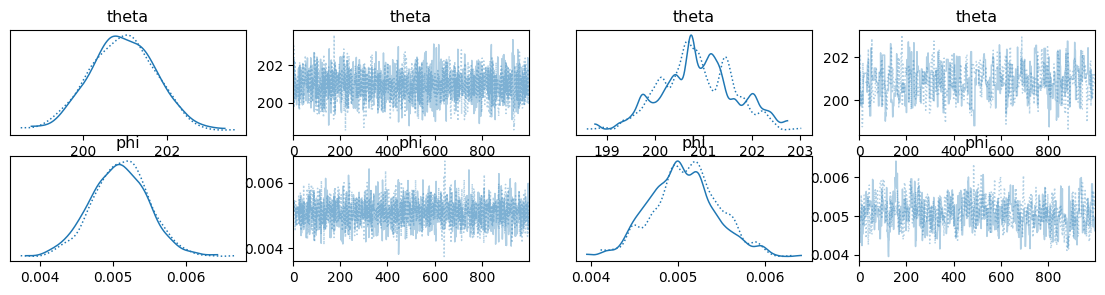

In [55]:
# HMC performs a rather satisfactory result, but MH subplots indicate signs of deviation away from the dotted lines.
# Split of Rhats values are all below 1.05, which aren't rejected by the similarity test.
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})

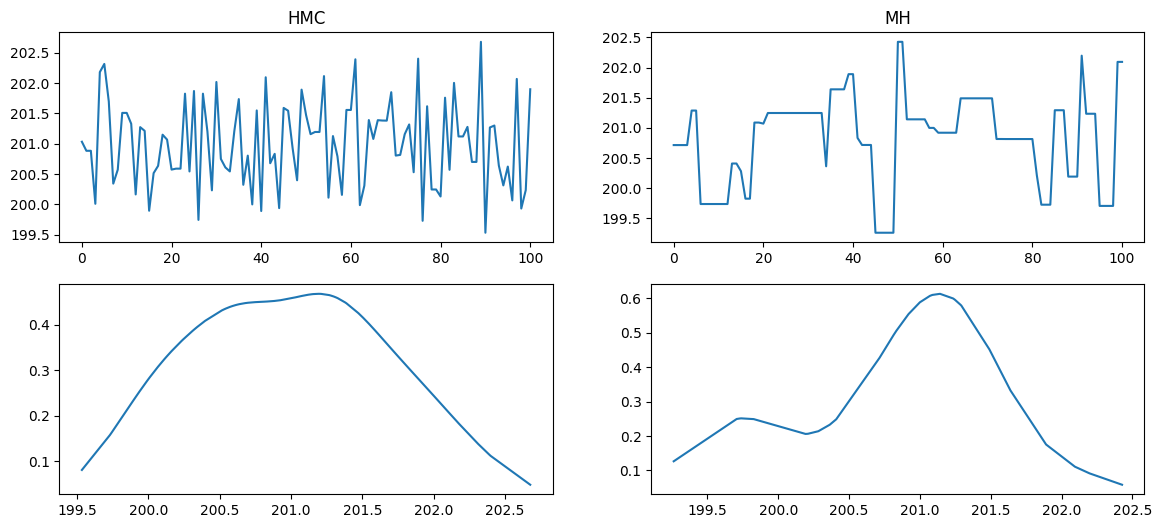

In [56]:
# Plot the first 100 iterations of theta for HMC and MH
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain); ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,0].set_title("HMC");
mcmc_chain = idata_MH.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain); ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted)); ax[0,1].set_title("MH");

Autocorrelation for HMC (MCMC) chain -0.06310930861110063
Autocorrelation for MH (MCMC) chain 0.6982305083216298


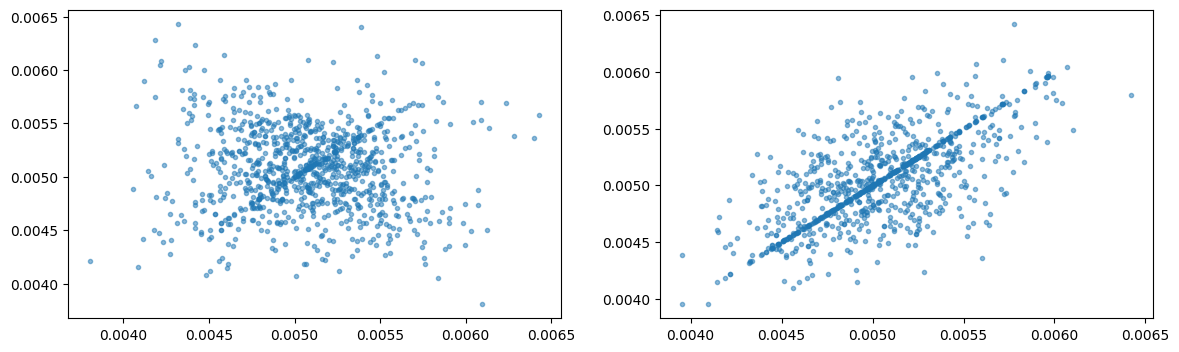

In [57]:
# The autocorrelation for the HMC chain is smaller than the autocorrelation for the MH chain.
import numpy as np; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_MH.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_MH.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [58]:
# Check the effective size of the HMC and MH chains
# Effective sample size is rather low
import arviz as az; print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html
print("number of MCMC samples:", idata_MH.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_MH, round_to=2)

number of MCMC samples: 2000
number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,200.88,0.75,199.52,202.26,0.04,0.03,433.04,419.17,1.01
phi,0.01,0.00,0.00,0.01,0.00,0.00,241.46,442.02,1.01


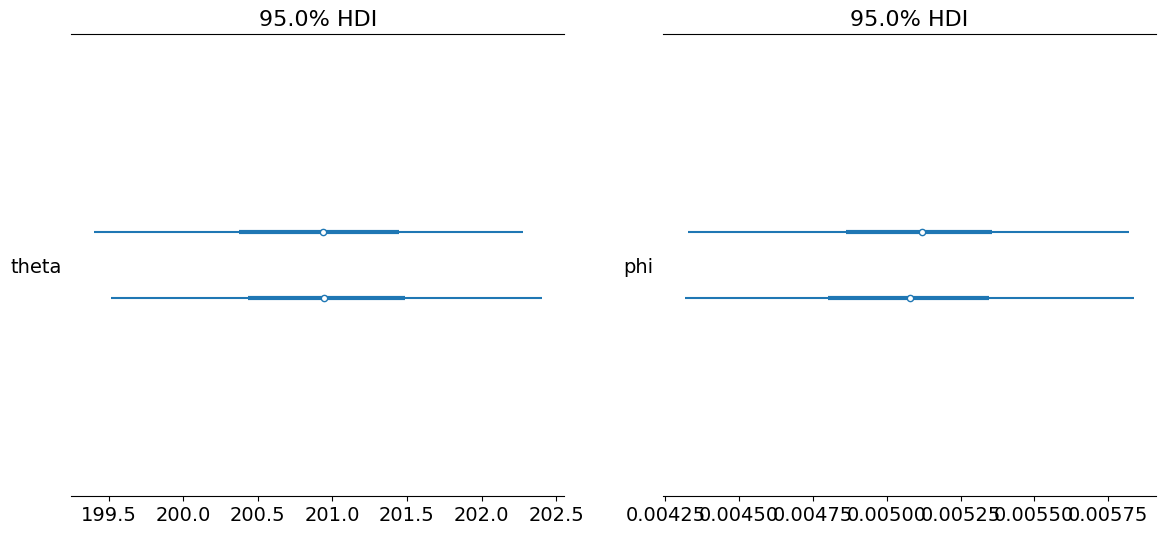

In [59]:
# 95% credible interval of theta and phi
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,2, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1]);